In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants
Thickness = 0.006035  # m (6.035mm)
Width = 0.02  # m (20 mm)
area = Thickness * Width  # Calculate the area of the specimen

# Load tensile test data
df = pd.read_csv('Zy1.csv', delimiter=';', header=[0, 1])

In [11]:
df

,Time,Crosshead separation,Load,Extensometer elongation
,(sec),(mm),(kN),(%)
0,0,"-0,00004","0,26954","-0,06349"
1,"0,1","0,00136","0,27102","-0,06347"
2,"0,2","0,00328","0,27345","-0,06345"
3,"0,3","0,00592","0,28039","-0,06342"
4,"0,4","0,00936","0,30209","-0,06336"
...,...,...,...,...
11775,"1165,04212","26,25784","37,34536",NaN
11776,"1165,04413","26,25796","34,73364",NaN
11777,"1165,046","26,25824","32,05628",NaN


In [12]:
# Merge headers and clean column names
df.columns = [f"{col[0]} {col[1]}" for col in df.columns]
df.columns = df.columns.str.strip()
df = df.apply(lambda x: x.astype(str).str.replace(',', '.')).astype(float)

In [13]:
df

,Time (sec),Crosshead separation (mm),Load (kN),Extensometer elongation (%)
0,0.00000,-0.00004,0.26954,-0.06349
1,0.10000,0.00136,0.27102,-0.06347
2,0.20000,0.00328,0.27345,-0.06345
3,0.30000,0.00592,0.28039,-0.06342
4,0.40000,0.00936,0.30209,-0.06336
...,...,...,...,...
11775,1165.04212,26.25784,37.34536,NaN
11776,1165.04413,26.25796,34.73364,NaN
11777,1165.04600,26.25824,32.05628,NaN
11778,1165.04812,26.25836,29.37563,NaN


In [14]:
# Extract relevant columns
time = df["Time (sec)"]
displacement = df["Crosshead separation (mm)"]
force = df["Load (kN)"]
elongation = df["Extensometer elongation (%)"]

# Calculate stress and strain
force = force * 1000  # Convert kN to N
stress = (force / area)  # N/m^2 or Pa
stress_MPa = stress / (1000 * 1000)  # Convert Pa to MPa
strain = elongation  # Keep strain in percentage

In [15]:
force

0          269.54
1          271.02
2          273.45
3          280.39
4          302.09
           ...   
11775    37345.36
11776    34733.64
11777    32056.28
11778    29375.63
11779    26704.22
Name: Load (kN), Length: 11780, dtype: float64

In [16]:
stress

0        2.233140e+06
1        2.245402e+06
2        2.265534e+06
3        2.323032e+06
4        2.502817e+06
             ...     
11775    3.094065e+08
11776    2.877684e+08
11777    2.655864e+08
11778    2.433772e+08
11779    2.212446e+08
Name: Load (kN), Length: 11780, dtype: float64

In [17]:
# Remove NaNs from stress and strain
valid_indices = ~np.isnan(stress_MPa) & ~np.isnan(strain)  # Mask for valid data
stress_MPa = stress_MPa[valid_indices]
strain = strain[valid_indices]

In [18]:
# Shift the curve to start at (0, 0)
initial_strain = strain.iloc[0]  # First strain value
initial_stress = stress_MPa.iloc[0]  # First stress value

# Subtract the initial strain and stress values to shift the curve
strain_shifted = strain - initial_strain
stress_shifted = stress_MPa - initial_stress

# Ensure the first point is exactly (0, 0)
strain_shifted.iloc[0] = 0
stress_shifted.iloc[0] = 0

In [21]:
# Identify elastic region (assume up to 374 MPa is elastic)
elastic_region = stress_shifted <= 374

# Reset indices to ensure alignment
strain_shifted = strain_shifted.reset_index(drop=True)
stress_shifted = stress_shifted.reset_index(drop=True)
elastic_region = elastic_region.reset_index(drop=True)

# Extract elastic region data
elastic_strain = strain_shifted[elastic_region]
elastic_stress = stress_shifted[elastic_region]

# Convert elastic strain to decimal for Young's Modulus calculation ONLY
elastic_strain_decimal = elastic_strain / 100  # Convert percentage to decimal

In [29]:
elastic_strain_decimal

0      0.000000e+00
1      2.000000e-07
2      4.000000e-07
3      7.000000e-07
4      1.300000e-06
           ...     
427    1.957200e-03
428    1.965200e-03
429    1.973500e-03
430    1.981900e-03
431    1.990500e-03
Name: Extensometer elongation (%), Length: 432, dtype: float64

In [30]:
# Fit a linear regression to the elastic region to find Young’s Modulus
E, intercept = np.polyfit(elastic_strain_decimal, elastic_stress, 1)
print(f"Young's Modulus is: {E} MPa")
E_GPa = E / 1000  # Convert MPa to GPa
print(f"Intercept: {intercept} MPa")

# Calculate 0.2% Offset Yield Strength (strain remains in percentage)
offset_strain = strain_shifted + 0.2  # 0.2% offset strain (in percentage)
offset_stress = E * (offset_strain / 100) + intercept  # Convert offset strain to decimal for calculation
yield_strength = np.interp(0.2, strain_shifted, stress_shifted)  # Yield strength at 0.2% offset

Young's Modulus is: 198155.98791883187 MPa
Intercept: 4.6504842266367294 MPa


In [28]:
elastic_stress

0        0.000000
1        0.012262
2        0.032394
3        0.089892
4        0.269677
          ...    
427    369.945485
428    370.825518
429    371.670837
430    372.543745
431    373.380613
Name: Load (kN), Length: 432, dtype: float64

In [27]:
elastic_strain_decimal

0      0.000000e+00
1      2.000000e-07
2      4.000000e-07
3      7.000000e-07
4      1.300000e-06
           ...     
427    1.957200e-03
428    1.965200e-03
429    1.973500e-03
430    1.981900e-03
431    1.990500e-03
Name: Extensometer elongation (%), Length: 432, dtype: float64

In [17]:
stress_shifted

0         0.000000
1         0.012262
2         0.032394
3         0.089892
4         0.269677
           ...    
1950    450.001160
1951    450.041342
1952    450.053190
1953    450.055841
1954    450.056669
Name: Load (kN), Length: 1955, dtype: float64

In [15]:
yield_strength

np.float64(374.33564320490024)

Young's Modulus is: 198155.98791883187 MPa
Intercept: 4.6504842266367294 MPa


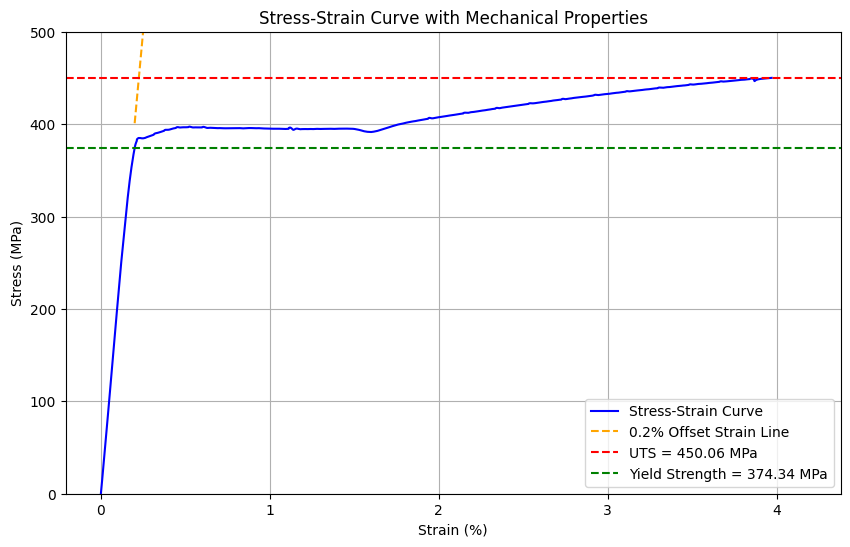

Young's Modulus (E): 198.16 GPa
Ultimate Tensile Strength (UTS): 450.06 MPa
Yield Strength: 374.34 MPa


In [12]:
# Calculate Ultimate Tensile Strength (UTS)
uts = stress_shifted.max()


# Convert strain from percentage to decimal for toughness calculation
strain_decimal = strain_shifted / 100  # Convert percentage to decimal
# Calculate Toughness (area under stress-strain curve)
#toughness_mj_per_m3 = np.trapeziod(stress_shifted, strain_decimal)  # MPa is equivalent to MJ/m³ # trapz is depricated

# Plot stress-strain curve (strain remains in percentage)
plt.figure(figsize=(10, 6))
plt.plot(strain_shifted, stress_shifted, label='Stress-Strain Curve', color='blue')
#plt.fill_between(strain_shifted, stress_shifted, color='lightblue', alpha=0.5, label=f'Toughness = {toughness_mj_per_m3:.2f} MJ/m³')

# Plot the 0.2% offset line
plt.plot(offset_strain, offset_stress, linestyle='--', color='orange', label='0.2% Offset Strain Line')

# Highlight key points
plt.axhline(y=uts, color='red', linestyle='--', label=f'UTS = {uts:.2f} MPa')
plt.axhline(y=yield_strength, color='green', linestyle='--', label=f'Yield Strength = {yield_strength:.2f} MPa')

plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.title('Stress-Strain Curve with Mechanical Properties')
plt.legend()
plt.grid(True)
plt.ylim(0, 500)

# Save and show plot
plt.savefig("Stress_Tensile_Test_Results.png", dpi=300, bbox_inches='tight')
plt.show()

# Print results
print(f"Young's Modulus (E): {E_GPa:.2f} GPa")
print(f"Ultimate Tensile Strength (UTS): {uts:.2f} MPa")
print(f"Yield Strength: {yield_strength:.2f} MPa")
#print(f"Toughness: {toughness_mj_per_m3:.2f} MJ/m³")

In [14]:
offset_stress

0        400.962460
1        401.002091
2        401.041722
3        401.101169
4        401.220063
           ...     
1950    8263.673167
1951    8267.438131
1952    8269.102641
1953    8269.934896
1954    8270.014159
Name: Extensometer elongation (%), Length: 1955, dtype: float64